# **Importing Libraries**

In [1]:
!pip install torchmetrics

In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.datasets import ImageFolder
import math
from torchvision.models import vgg19
import random
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

# **Device**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Hyperparameters**

In [4]:
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
batch_size = 16
epochs = 50
learning_rate = 3e-4
num_classes = 4

In [5]:
small_kernel_size = 3
large_kernel_size = 9
channels = 64
in_channels = 3
out_channels = 3
scaling_factor = 2
res_blocks = 16
img_size = 256
num_workers = 2

# **Checkpointing**

In [6]:
def save_checkpoint(epoch, model, optimizer, t_loss, v_loss, root_dir):
    checkpoint = os.path.join(root_dir, 'checkpoint.pt')
    torch.save({
        'epoch' : epoch,
        't_loss' : t_loss,
        'v_loss' : v_loss,
        'model' : model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, checkpoint)
    print(f'Checkpoint Saved at epoch{epoch+1}')

def load_checkpoint(model, optimizer, root_dir):
    checkpoint = os.path.join(root_dir, 'checkpoint.pt')
    if os.path.exists(checkpoint):
        checkpoint_file = torch.load(checkpoint)
        epochs = checkpoint_file['epoch']
        t_loss = checkpoint_file['t_loss']
        v_loss = checkpoint_file['v_loss']
        model = model.load_state_dict(checkpoint_file['model'])
        optimizer = optimizer.load_state_dict(checkpoint_file['optimizer'])
        return epochs + 1, t_loss, v_loss
    
    else:
        return 0, [], []

In [7]:
def save_checkpoint_gan(epoch, gen, disc, gen_opt, disc_opt, gen_losses, disc_losses, root_dir):
    checkpoint_gan = os.path.join(root_dir, 'checkpoint_gan.pt')
    torch.save({
        'epoch' : epoch,
        'gen_losses' : gen_losses,
        'disc_losses' : disc_losses,
        'gen' : gen.state_dict(),
        'disc' : disc.state_dict(),
        'gen_opt': gen_opt.state_dict(),
        'disc_opt': disc_opt.state_dict(),
    }, checkpoint_gan)
    print(f'Checkpoint Saved at epoch{epoch+1}')

def load_checkpoint_gan(gen, disc, gen_opt, disc_opt, root_dir):
    checkpoint_gan = os.path.join(root_dir, 'checkpoint_gan.pt')
    if os.path.exists(checkpoint_gan):
        checkpoint_file_gan = torch.load(checkpoint_gan)
        epochs = checkpoint_file_gan['epoch']
        gen_losses = checkpoint_file_gan['gen_losses']
        disc_losses = checkpoint_file_gan['disc_losses']
        gen = gen.load_state_dict(checkpoint_file_gan['gen'])
        disc = disc.load_state_dict(checkpoint_file_gan['disc'])
        gen_opt = gen_opt.load_state_dict(checkpoint_file_gan['gen_opt'])
        disc_opt = disc_opt.load_state_dict(checkpoint_file_gan['disc_opt'])
        return epochs + 1, gen_losses, disc_losses
    
    else:
        return 0, [], []

# **Custom Dataset**

In [8]:
# Define the transformations on the data
low_res_size = 128
high_res_size = 256


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

denormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
   # transforms.Normalize(std = std , mean = mean)
    
])


transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
    #transforms.Normalize(std = std , mean = mean)
])

In [9]:
class ImageDataset(Dataset):
    # This is a custom dataset created using pytorch Dataset
    def __init__(self, root_dir):
        super(ImageDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "low_res"))
        files_high = os.listdir(os.path.join(root_dir, "high_res"))
        self.data = list(zip(files_low, files_high))

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        
        # Get the path for the image LR and HR
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)

        # Open the actual image
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]
        
        # Apply the transformation to the image
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)
        
        return low_res, high_res

In [10]:
train_data = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/train")
val_data = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# **SR-ResNet Model**

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, kernel_size, channels):
        super().__init__()
        self.conv = nn.Sequential(
            self.block(channels, channels, kernel_size, 1, kernel_size//2),
            nn.PReLU(),
            self.block(channels, channels, kernel_size, 1, kernel_size//2)
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels)
        )
        return self.layer
    
    def forward(self, x):
        residual = x
        y = self.conv(x)
        output = y + residual
        return output

In [12]:
class SubPixelConvBlock(nn.Module):
    def __init__(self, kernel_size, channels, scaling_factor = 2):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels*(scaling_factor**2), kernel_size, padding = kernel_size//2)
        self.pixel_shuffle = nn.PixelShuffle(scaling_factor)
        self.prelu = nn.PReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

image(b, c, h, w) --> pixel_shuffle(image)(b, c/r^2, h*r, w*r), where r is scaling factor

In [13]:
class SR_ResNet(nn.Module):
    def __init__(self, large_kernel_size, small_kernel_size, channels, res_blocks, scaling_factor):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, channels, large_kernel_size, stride = 1, padding = large_kernel_size//2),
            nn.BatchNorm2d(channels),
            nn.PReLU()
        )
        
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(small_kernel_size, channels) for i in range(res_blocks)]
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels, small_kernel_size, stride = 1, padding = 1),
            nn.BatchNorm2d(channels)
        )
        
        n_subPix = int(math.log2(scaling_factor))
        self.subPix_blocks = nn.Sequential(
            *[SubPixelConvBlock(small_kernel_size, channels, scaling_factor) for i in range(n_subPix)]
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(channels, out_channels, large_kernel_size, stride = 1, padding = large_kernel_size//2),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        residual = x
        y = self.residual_blocks(x)
        y = self.conv2(x)
        y = y + residual
        y = self.subPix_blocks(y)
        y = self.conv3(y)
        return y

# **SR-ResNet Training**

In [14]:
model = SR_ResNet(large_kernel_size, small_kernel_size, channels, res_blocks=3, scaling_factor=2).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()
model.load_state_dict(torch.load("/kaggle/input/checkpoints/model_SR-ResNet.pth"))

<All keys matched successfully>

In [15]:
checkpoint_dir_resnet = '/kaggle/working/checkpoints_resnet'
os.makedirs(checkpoint_dir_resnet, exist_ok=True)

In [16]:
start_epoch, t_loss, v_loss = load_checkpoint(model, optimizer, checkpoint_dir_resnet)
best_val_loss = float("inf")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (lr, hr) in enumerate(train_loader):
        hr = hr.to(device)
        lr = lr.to(device)
        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader)
    t_loss.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (lr, hr) in enumerate(val_loader):
            hr = hr.to(device)
            lr = lr.to(device)
            sr = model(lr)
            valid_loss = criterion(sr, hr)
            val_loss += valid_loss.item()
        val_loss = val_loss/len(val_loader)
        v_loss.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"/kaggle/working/checkpoints_resnet/model.pth")
                
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}')
    print(f'Epoch {epoch+1}, Val Loss: {val_loss}')
    save_checkpoint(epoch, model, optimizer, t_loss, v_loss, checkpoint_dir_resnet)

Epoch 1, Train Loss: 0.004266314812242811
Epoch 1, Val Loss: 0.0033268463289873166
Checkpoint Saved at epoch1
Epoch 2, Train Loss: 0.0031654031752327153
Epoch 2, Val Loss: 0.00255549773150547
Checkpoint Saved at epoch2
Epoch 3, Train Loss: 0.003259189326727633
Epoch 3, Val Loss: 0.0018770842791788957
Checkpoint Saved at epoch3
Epoch 4, Train Loss: 0.0037258798148223134
Epoch 4, Val Loss: 0.0043340538078072395
Checkpoint Saved at epoch4
Epoch 5, Train Loss: 0.004781700194228527
Epoch 5, Val Loss: 0.0024010047570548272
Checkpoint Saved at epoch5
Epoch 6, Train Loss: 0.004030809889352599
Epoch 6, Val Loss: 0.001846319805322723
Checkpoint Saved at epoch6
Epoch 7, Train Loss: 0.0037116343886483202
Epoch 7, Val Loss: 0.0021059176122600384
Checkpoint Saved at epoch7
Epoch 8, Train Loss: 0.0026362088730905293
Epoch 8, Val Loss: 0.0017174440965225751
Checkpoint Saved at epoch8
Epoch 9, Train Loss: 0.0031601728189216798
Epoch 9, Val Loss: 0.0017769394590604034
Checkpoint Saved at epoch9
Epoch 10

# **Visualizing SR-ResNet Results**

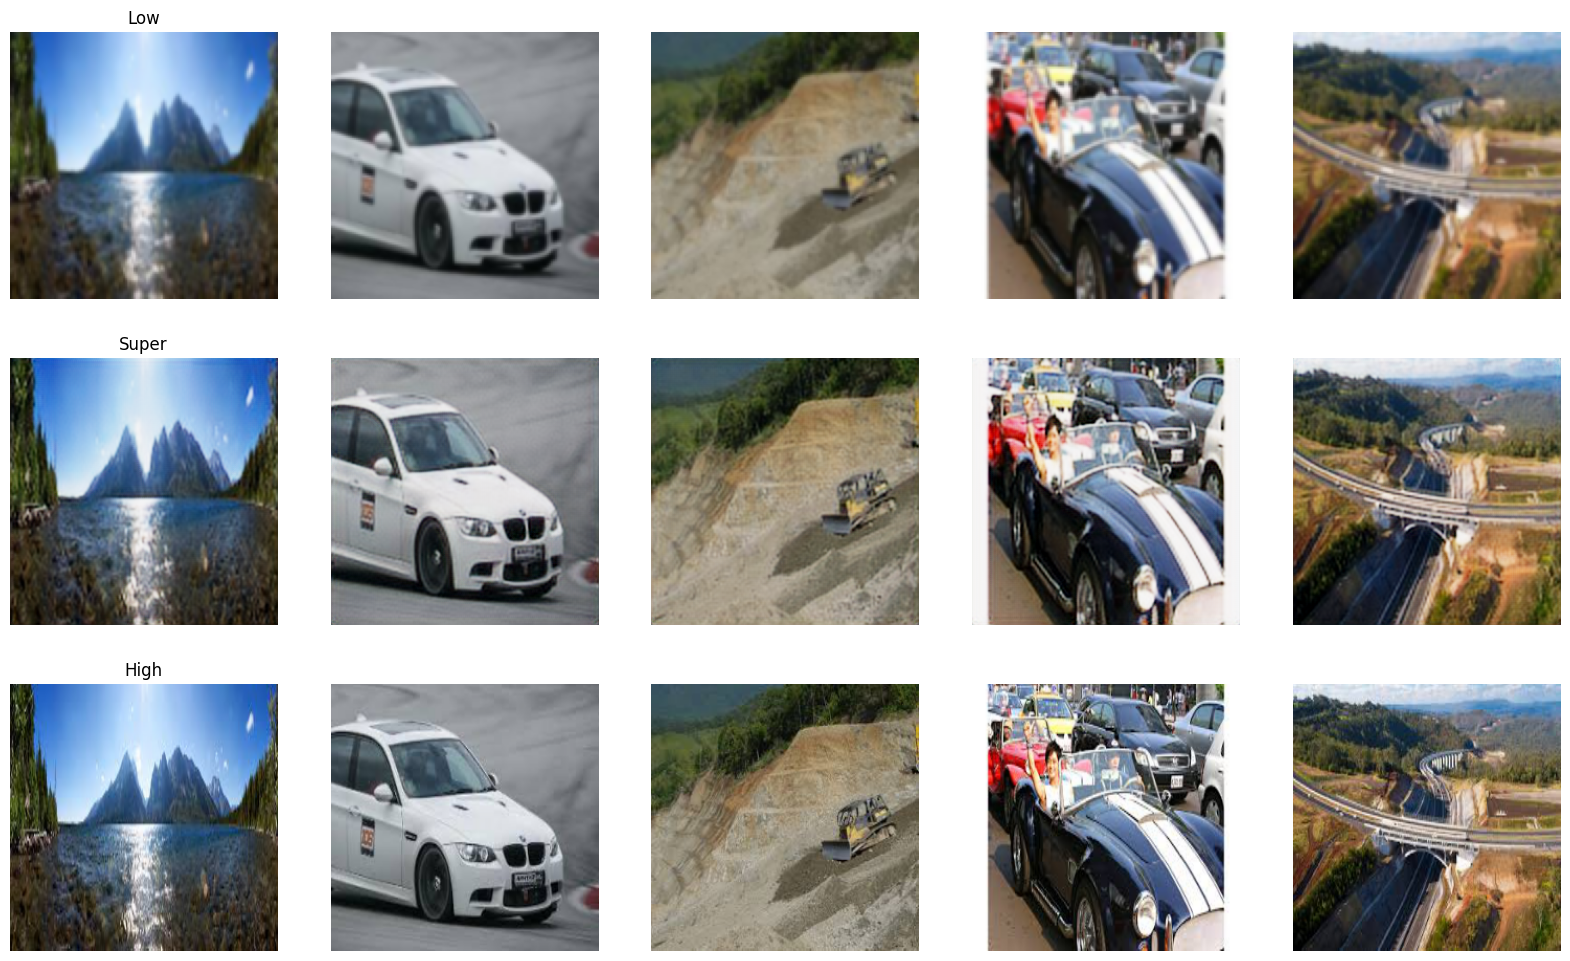

In [15]:
low_res = next(iter(val_loader))[0].to(device)
high_res = next(iter(val_loader))[1].to(device)

model.eval()
super_res = model(low_res)

fig, ax = plt.subplots(3, 5, figsize=(20, 12))
ax[0, 0].set_title("Low")
ax[1, 0].set_title("Super")
ax[2, 0].set_title("High")
for i in range(5):
    ax[0, i].imshow(low_res[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[1, i].imshow(super_res[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[2, i].imshow(high_res[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
plt.show()

In [20]:
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)

model.eval()
with torch.no_grad():
    for batch_idx, (lr, hr) in enumerate(val_loader):
        hr = hr.to(device)
        lr = lr.to(device)
        sr = model(lr)
        psnr.update(sr, hr)
        ssim.update(sr, hr)
        
psnr_value = psnr.compute()
ssim_value = ssim.compute()
print("PSNR:", psnr_value.item())
print("SSIM:", ssim_value.item())

PSNR: 27.701717376708984
SSIM: 0.8708662390708923


# **Loss functions for SR-GAN**

In [19]:
def get_gen_loss(disc_fakes):
    return torch.sum(torch.log(1 - disc_fakes + 1e-6))

def get_disc_loss(disc_reals, disc_fakes):
    return -1 * torch.sum(torch.log(disc_reals + 1e-6) + torch.log(1 - disc_fakes + 1e-6))

In [20]:
test_vgg_model = vgg19(weights=True).eval().to(device)
lf = list(test_vgg_model.features)
lf[25]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 167MB/s]  


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [21]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

# **Discriminator of SR-GAN**

In [22]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, stride=1),
            nn.LeakyReLU(0.2),
            self.block(features, features, 3, 2),
            self.block(features, features*2, 3, 1),
            self.block(features*2, features*2, 3, 2),
            self.block(features*2, features*4, 3, 1),
            self.block(features*4, features*4, 3, 2),
            self.block(features*4, features*8, 3, 1),
            self.block(features*8, features*8, 3, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(features*8*6*6, features*16),
            nn.LeakyReLU(0.2),
            nn.Linear(features*16, 1),
            nn.Sigmoid()
        )

    def block(self, in_channels, out_channels, kernel_size, stride):
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
        return self.layer
    
    def forward(self, x):
        x = self.disc(x)
        x = self.classifier(x)
        return x

# **Training SR-GAN**

In [23]:
vgg_loss = vggL()
def train_gen(gen, disc, gen_opt, lr):
    gen.train()
    gen_opt.zero_grad()
    sr = gen(lr)
    disc_fake = disc(sr)
    gen_loss = get_gen_loss(disc_fake)
    content_loss = 0.006 * vgg_loss(sr, hr)
    adversarial_loss = 1e-3 * gen_loss
    total_loss = adversarial_loss + content_loss
    total_loss.backward()
    gen_opt.step()
    return total_loss.item()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [24]:
def train_disc(disc, gen, disc_opt, lr, hr):
    disc.train()
    disc_opt.zero_grad()
    real_pred = disc(hr)
    fake_data = gen(lr)
    fake_pred = disc(fake_data.detach())
    disc_loss = get_disc_loss(real_pred, fake_pred)
    disc_loss.backward()
    disc_opt.step()
    return disc_loss.item()

In [25]:
checkpoint_dir_gan = '/kaggle/working/checkpoints_gan'
os.makedirs(checkpoint_dir_gan, exist_ok=True)

In [26]:
gen = SR_ResNet(large_kernel_size, small_kernel_size, channels, res_blocks=3, scaling_factor=2).to(device)
disc = Discriminator(3, 64).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
checkpoint = torch.load('/kaggle/input/checkpoints/checkpoint_gan.pt')
gen.load_state_dict(checkpoint['gen'])
disc.load_state_dict(checkpoint['disc'])

<All keys matched successfully>

In [27]:
start_epoch, gen_losses, disc_losses = load_checkpoint_gan(gen, disc, gen_opt, disc_opt, checkpoint_dir_gan)
for epoch in range(epochs):
    curr_gen_loss = 0
    curr_disc_loss = 0
    for batch_idx, (lr, hr) in enumerate(train_loader):
        hr = hr.to(device)
        lr = lr.to(device)
        disc_loss = train_disc(disc, gen, disc_opt, lr, hr)
        gen_loss = train_gen(gen, disc, gen_opt, lr)
        curr_gen_loss += gen_loss
        curr_disc_loss += disc_loss
        
    gen_losses.append(curr_gen_loss/len(train_loader))
    disc_losses.append(curr_disc_loss/len(train_loader))
    
    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {disc_losses[-1]:.4f}, Loss G: {gen_losses[-1]:.4f}")
    save_checkpoint_gan(epoch, gen, disc, gen_opt, disc_opt, gen_losses, disc_losses, checkpoint_dir_gan)

Epoch [1/50] Loss D: 3.4848, Loss G: 0.0023
Checkpoint Saved at epoch1
Epoch [2/50] Loss D: 0.1322, Loss G: 0.0037
Checkpoint Saved at epoch2
Epoch [3/50] Loss D: 0.0416, Loss G: 0.0028
Checkpoint Saved at epoch3
Epoch [4/50] Loss D: 0.0479, Loss G: 0.0026
Checkpoint Saved at epoch4
Epoch [5/50] Loss D: 0.0178, Loss G: 0.0029
Checkpoint Saved at epoch5
Epoch [6/50] Loss D: 0.0211, Loss G: 0.0025
Checkpoint Saved at epoch6
Epoch [7/50] Loss D: 0.0065, Loss G: 0.0025
Checkpoint Saved at epoch7
Epoch [8/50] Loss D: 0.0037, Loss G: 0.0026
Checkpoint Saved at epoch8
Epoch [9/50] Loss D: 0.0008, Loss G: 0.0027
Checkpoint Saved at epoch9
Epoch [10/50] Loss D: 0.0025, Loss G: 0.0024
Checkpoint Saved at epoch10
Epoch [11/50] Loss D: 6.6400, Loss G: 0.0047
Checkpoint Saved at epoch11
Epoch [12/50] Loss D: 1.5723, Loss G: 0.0048
Checkpoint Saved at epoch12
Epoch [13/50] Loss D: 0.2381, Loss G: 0.0035
Checkpoint Saved at epoch13
Epoch [14/50] Loss D: 0.0779, Loss G: 0.0029
Checkpoint Saved at epoc

# **Visualizing SR-GAN Results**

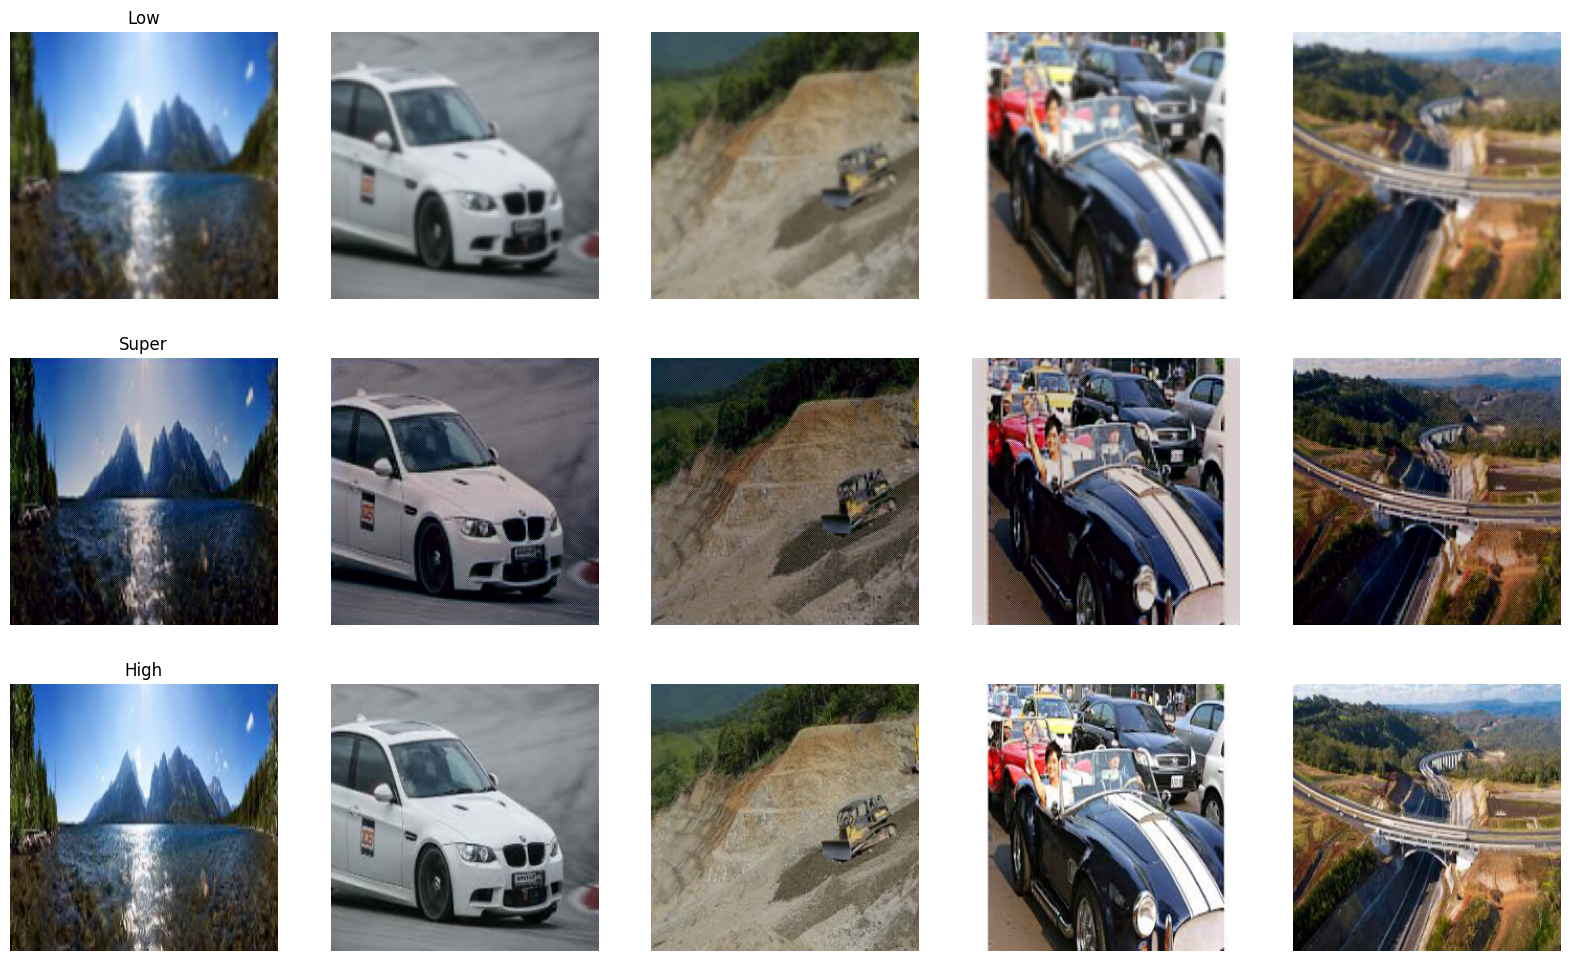

In [30]:
low_res = next(iter(val_loader))[0].to(device)
high_res = next(iter(val_loader))[1].to(device)

gen.eval()
super_res = gen(low_res)

fig, ax = plt.subplots(3, 5, figsize=(20, 12))
ax[0, 0].set_title("Low")
ax[1, 0].set_title("Super")
ax[2, 0].set_title("High")
for i in range(5):
    ax[0, i].imshow(low_res[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[1, i].imshow(super_res[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[2, i].imshow(high_res[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
plt.show()

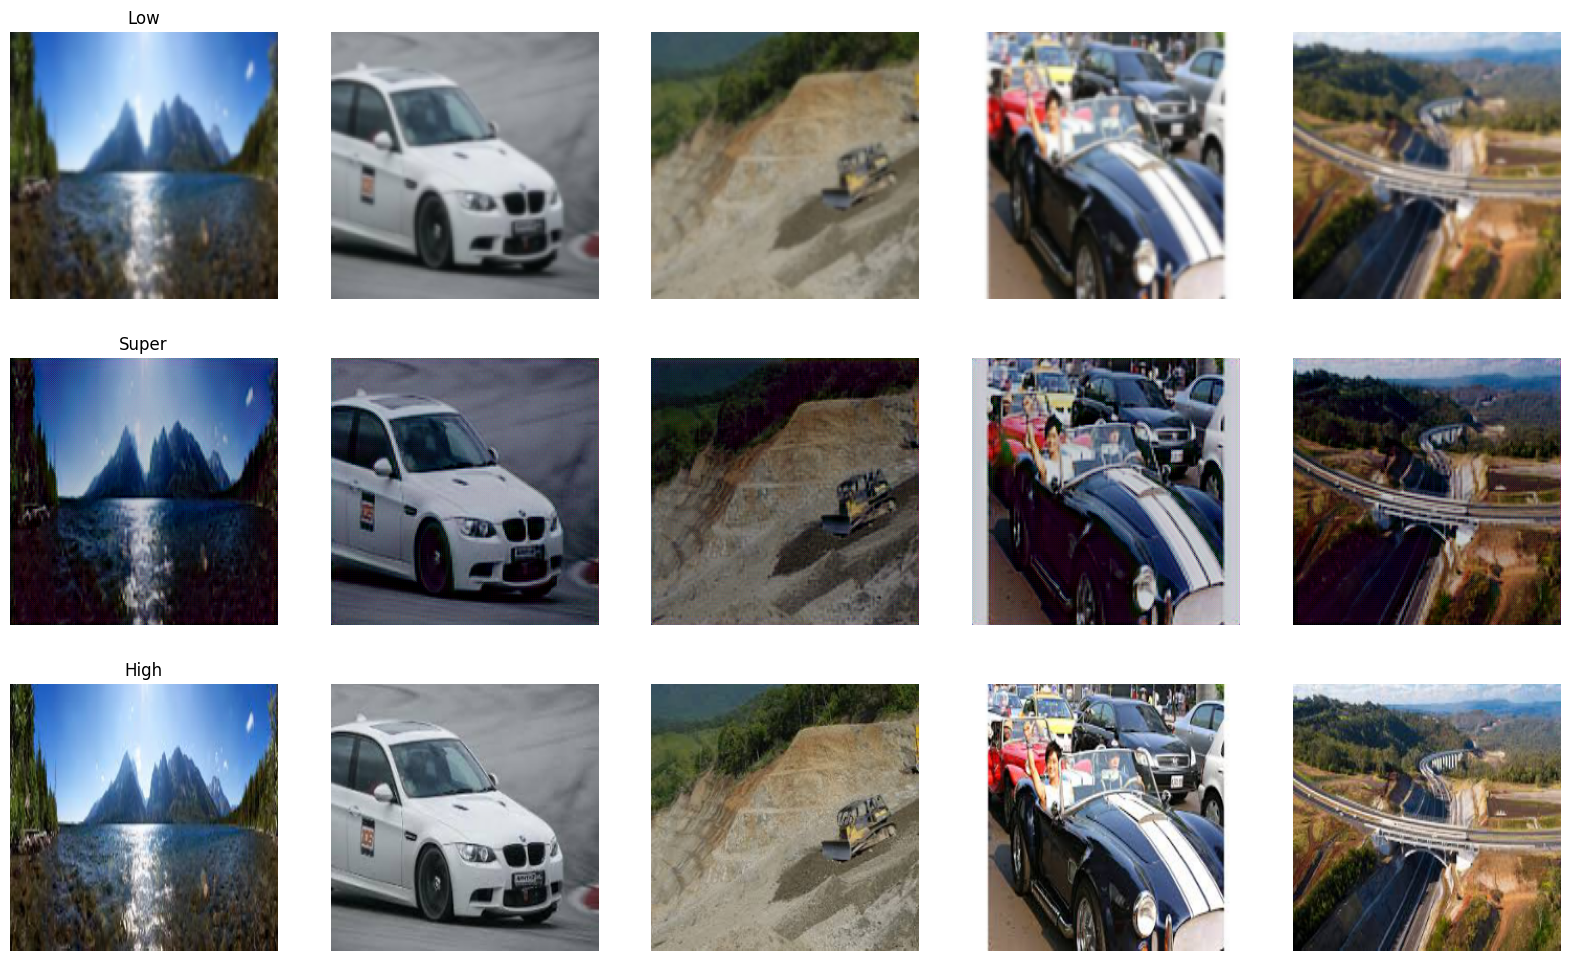

In [30]:
low_res = next(iter(val_loader))[0].to(device)
high_res = next(iter(val_loader))[1].to(device)

gen.eval()
super_res = gen(low_res)

fig, ax = plt.subplots(3, 5, figsize=(20, 12))
ax[0, 0].set_title("Low")
ax[1, 0].set_title("Super")
ax[2, 0].set_title("High")
for i in range(5):
    ax[0, i].imshow(low_res[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[1, i].imshow(super_res[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[2, i].imshow(high_res[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
plt.show()

# **Comparing SR-ResNet and SR-GAN Results**

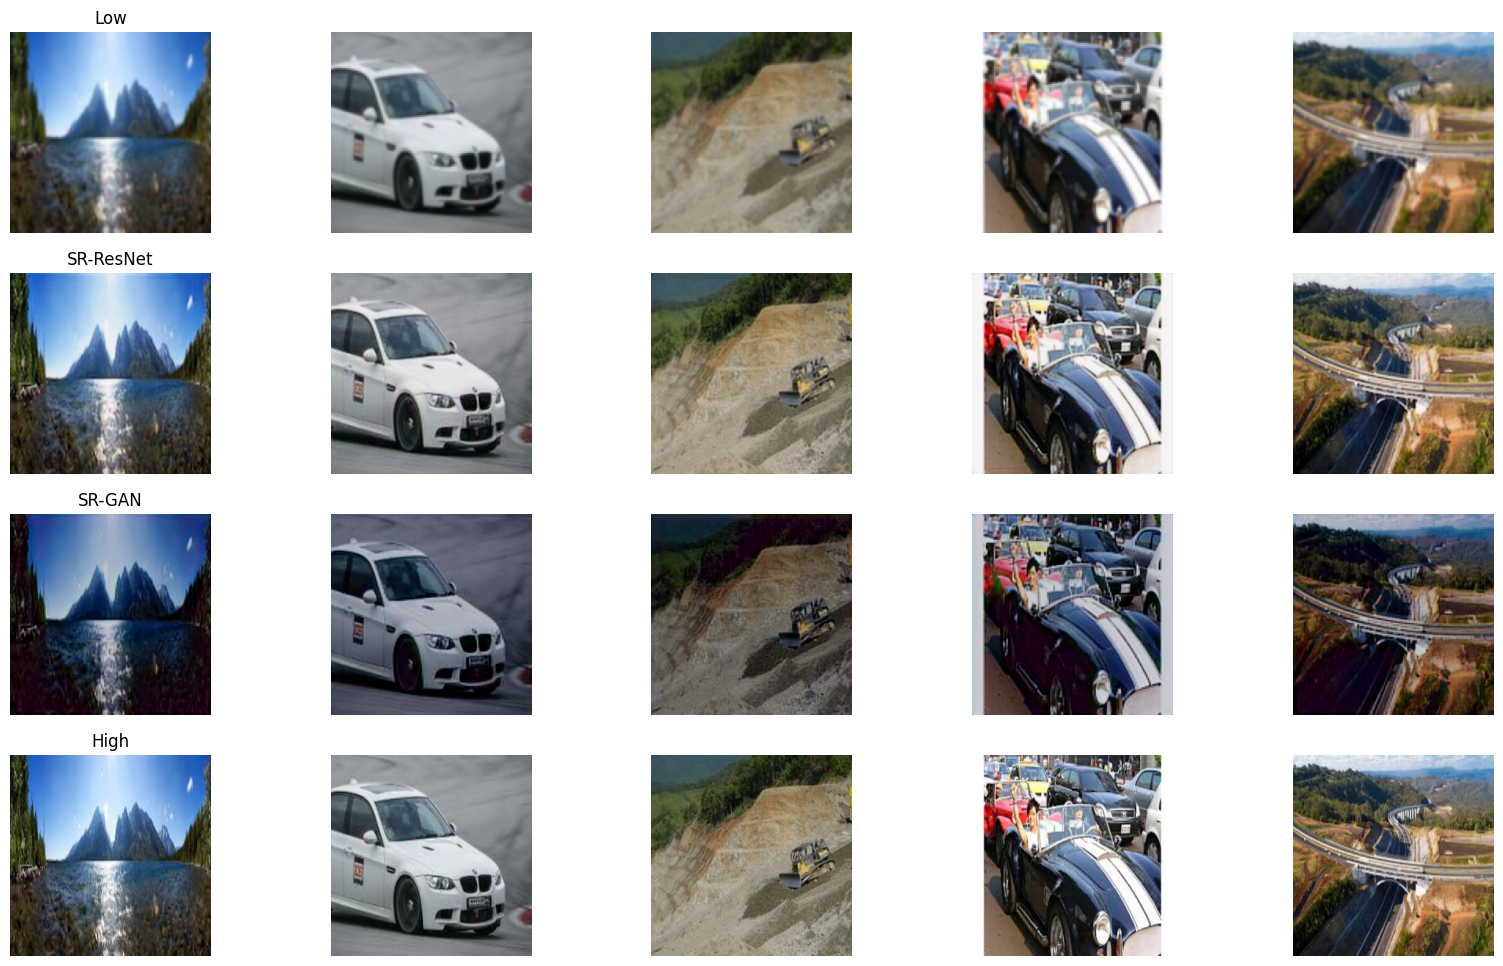

In [34]:
lr = next(iter(val_loader))[0].to(device)
hr = next(iter(val_loader))[1].to(device)

gen.eval()
sr_gan = gen(lr)
model.eval()
sr_resnet = model(lr)

fig, ax = plt.subplots(4, 5, figsize=(20, 12))
ax[0, 0].set_title("Low")
ax[1, 0].set_title("SR-ResNet")
ax[2, 0].set_title("SR-GAN")
ax[3, 0].set_title("High")
for i in range(5):
    ax[0, i].imshow(lr[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[1, i].imshow(sr_resnet[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[2, i].imshow(sr_gan[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[3, i].imshow(hr[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[3, i].axis('off')
plt.show()

In [29]:
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)

gen.eval()
with torch.no_grad():
    for batch_idx, (lr, hr) in enumerate(val_loader):
        hr = hr.to(device)
        lr = lr.to(device)
        sr = gen(lr)
        psnr.update(sr, hr)
        ssim.update(sr, hr)
        
psnr_value = psnr.compute()
ssim_value = ssim.compute()
print("PSNR:", psnr_value.item())
print("SSIM:", ssim_value.item())

PSNR: 15.234709739685059
SSIM: 0.40931734442710876
